In [1]:
# Standard Library Imports
import os
import re
import time
import multiprocessing

# Third Party Imports
import pprint
from glob import glob
import numpy as np
import webbpsf
from astropy.io import fits
from astropy.io import ascii as asc
import matplotlib.pyplot as plt

# Local Imports (from nircam_simulator package)
from mirage import imaging_simulator
from mirage.seed_image import catalog_seed_image
from mirage.dark import dark_prep
from mirage.ramp_generator import obs_generator
from mirage.apt import apt_inputs
from mirage.yaml import yaml_generator, write_observationlist
from mirage.catalogs import get_catalog
from mirage.psf import psf_library

# View matplotlib plots inline
%matplotlib inline

/user/lchambers/miniconda3/envs/mirage_linux/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/user/lchambers/miniconda3/envs/mirage_linux/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
# Where the pointing and XML file for this particular OTE CAR are located
ote_dir = '/user/lchambers/OTECommSims/OTE06-1140_withPSFs/'

# Where the output FITS files will be saved to
library_root_dir = '/user/lchambers/OTECommSims/test_library_output/'

---
# First, generate (fake) PSF library files

Let's simulate Image Array 1 (OTE-06).
It has 6 observations:
- The first 5 observations are WFSC Commissioning observations, that each include 18 WFC groups. (18 sets of image-move-image. Right?)
- The last observation is simply NIRCam imaging to see how we did.

So I will need 5 x 18 = 90 distinct PSF library files. 

### Define location of APT files and catalogs

In [3]:
prop_id = 1140

# Change if you put your files somewhere else
ote_dir = '/user/lchambers/OTECommSims/OTE06-1140_withPSFs/'

# Change if you named your files differently.
root = 'OTE06-{}_withPSFs'.format(prop_id)

pointing_file = os.path.join(ote_dir, 'OTE06-1140.pointing')
xml_file = os.path.join(ote_dir, 'OTE06-1140.xml')

In [4]:
# Get SW and LW catalogs
cats = get_catalog.get_all_catalogs(pointing_file, prop_id)
target_coords, catalog_filenames_sw, catalog_filenames_lw = cats

Target coordinates:  146.87731 63.24781
Shortwave catalog file 2MASS_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.
Longwave catalog file WISE_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.


### Get the observation/visit information from the APT files

In [5]:
# Get the information from the pointing file
apt_prop = apt_inputs.AptInput()
pointing_tab = apt_prop.get_pointing_info(pointing_file, '1140')
n_exposures = len(pointing_tab['visit_id'])

In [6]:
print('You will be writing out {} individual FITS files.'.format(len(pointing_tab['visit_id'])))

You will be writing out 99 individual FITS files.


In [7]:
# Create dictionary that mirrors the program structure
program_structure = {}
for i in range(n_exposures):
    obs_num = pointing_tab['obs_num'][i]
    visit_num = pointing_tab['visit_num'][i]
    activity_id = pointing_tab['act_id'][i]
    
    obs_key = 'Observation{}'.format(obs_num)
    visit_key = 'Visit{}'.format(visit_num)
    
    program_structure.setdefault(obs_key, {})
    visit_dict = program_structure[obs_key].setdefault(visit_key, []).append('Activity{}'.format(activity_id))                                                                      
    
# pprint.pprint(program_structure)  

In [8]:
# Create directory structure based on dictionary

# program_dir = os.path.join(library_root_dir, 'OTE06-1140')
# for observation in program_structure.keys():
#     for visit in program_structure[observation].keys():
#         visit_dir = os.path.join(program_dir, observation, visit)
#         if not os.path.exists(visit_dir):
#             os.makedirs(visit_dir)

psf_paths = []
program_dir = os.path.join(library_root_dir, 'OTE06-1140')
for observation in program_structure.keys():
    for visit in program_structure[observation].keys():
        for activity in program_structure[observation][visit]:
            activity_dir = os.path.join(program_dir, observation, visit, activity)
            if not os.path.exists(activity_dir):
                os.makedirs(activity_dir)
            psf_paths.append(activity_dir)

## Generate the original PSF array

In [24]:
# Generate original PSF

# Let's go for a global alignment-esque thing, with the image array and random pistons.
nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)

# Set up the array
webbpsf.opds.setup_image_array(ote, reset=True, verbose=False, size='large', )

# Add random pistons
random_pistons = np.random.randn(18)*500  # substantial coarse phasing erorrs. 
for i, seg in enumerate(ote.segnames[0:18]):  # don't piston "segment 19" the SM
    ote.move_seg_local(seg, piston=random_pistons[i])


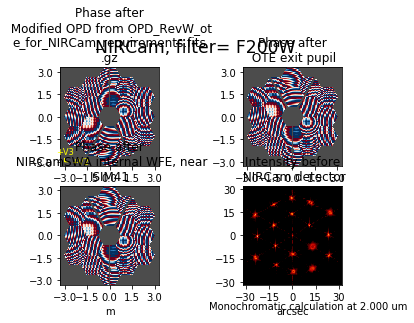

In [8]:
original_psf = nc.calc_psf(monochromatic=2e-6, oversample=1, fov_pixels=2048, display=True)

## Make slightly different PSFs for every exposure

In [29]:
def create_lib_for_random_ote(i):
    start_time = time.time()
    obs = 'Observation{}'.format(pointing_tab['obs_num'][i])
    visit = 'Visit{}'.format(pointing_tab['visit_num'][i])
    visit_dir = os.path.join(program_dir, obs, visit)
    
    print('Calculating PSF for obs {}, visit {}, exposure {}'
          .format(pointing_tab['obs_num'][i], pointing_tab['visit_num'][i], i + 1))

    i_seg = random_segments[i]
    ote.move_seg_local(ote.segnames[i_seg], piston = random_pistons[i])

    library_filename = 'nircam_f212n_fovp2048_samp1_npsf1_exp{}.fits'.format(i + 1)
    c = psf_library.CreatePSFLibrary('NIRCam', filters='F212N', detectors='NRCA3', 
                                     fov_pixels=2048, oversample=1, num_psfs=1, 
                                     fileloc=visit_dir, filename=library_filename,
                                     pupil_opd=ote, overwrite=False)
    c.create_files()
    
    print('Elapsed time: {}\n'.format(time.time() - start_time))

In [15]:
# Define a beep noise
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)

In [26]:
# Determine how many cores I have
multiprocessing.cpu_count()

32

In [28]:
# Generate PSF library files for each exposure - WITH MULTIPROCESSING!:
n_exposures = len(pointing_tab['visit_id'])

random_segments = np.random.randint(0, 17, n_exposures)
random_pistons = np.random.randn(n_exposures)*500

p = multiprocessing.Pool(30)
p.map(create_lib_for_random_ote, range(n_exposures))
    
beep(5)

Calculating PSF for obs 001, visit 001, exposure 3
Calculating PSF for obs 001, visit 001, exposure 5
Calculating PSF for obs 001, visit 001, exposure 6
Calculating PSF for obs 001, visit 001, exposure 4
Calculating PSF for obs 001, visit 001, exposure 8
Calculating PSF for obs 001, visit 001, exposure 7
Calculating PSF for obs 001, visit 001, exposure 9
Calculating PSF for obs 001, visit 001, exposure 10
Calculating PSF for obs 001, visit 001, exposure 1
Calculating PSF for obs 001, visit 001, exposure 2
Calculating PSF for obs 001, visit 001, exposure 11
Calculating PSF for obs 001, visit 001, exposure 12
Calculating PSF for obs 001, visit 001, exposure 14
Calculating PSF for obs 001, visit 001, exposure 15
Calculating PSF for obs 001, visit 001, exposure 16
Calculating PSF for obs 001, visit 001, exposure 17
Calculating PSF for obs 001, visit 001, exposure 13
Calculating PSF for obs 001, visit 001, exposure 18
Calculating PSF for obs 002, visit 001, exposure 20
Calculating PSF for o

ValueError: You are trying to apply a longwave filter (F480M) to a shortwave detector (NRCA3). Please change these entries so the filter falls within the detector band.

---
# Next, actually do MIRAGE simulations with these different PSFs

## Generate YAML files

In [20]:
# Create observation table file from APT files
observationlist_file = os.path.join(os.getcwd(), ote_dir, root + '_observationlist.yaml')
write_observationlist.write_yaml(xml_file, pointing_file, observationlist_file, 
                                 ps_cat_sw=catalog_filenames_sw, ps_cat_lw=catalog_filenames_lw)

Found 19 exposure(s) for observation 1 (Form medium array)
Found 19 exposure(s) for observation 2 (Clean up or form large array)
Found 19 exposure(s) for observation 3 (Form large array or clean up)
Found 19 exposure(s) for observation 4 (Clean up large array)
Found 19 exposure(s) for observation 5 (Clean up large array)
Found 4 exposure(s) for observation 6 (NIRCam Image Segments)

Successfully wrote 6 observations to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/OTE06-1140_withPSFs_observationlist.yaml


In [21]:
# Create a series of data simulator input yaml files from APT files
yam = yaml_generator.SimInput()

yam.input_xml = xml_file
yam.pointing_file = pointing_file
siaf_file = os.path.expandvars('$MIRAGE_DATA/nircam/reference_files/SIAF/NIRCam_SIAF_2018-01-08.csv')
yam.siaf = siaf_file
yam.output_dir = os.path.join(os.getcwd(), ote_dir)
yam.simdata_output_dir = os.path.join(os.getcwd(), ote_dir)
yam.observation_table = observationlist_file
yam.psf_paths = psf_paths

yam.use_JWST_pipeline = False # changed to False
yam.use_linearized_darks = True # changed to True
yam.datatype = 'linear'

yam.reffile_setup()
yam.create_inputs()

Using /user/lchambers/OTECommSims/OTE06-1140_withPSFs/OTE06-1140_withPSFs_observationlist.yaml, 
      /user/lchambers/OTECommSims/OTE06-1140_withPSFs/OTE06-1140.xml, 
      /user/lchambers/OTECommSims/OTE06-1140_withPSFs/OTE06-1140.pointing, and 
      /ifs/jwst/wit/mirage_data/nircam/reference_files/SIAF/NIRCam_SIAF_2018-01-08.csv 
      to generate observation table.

Found 19 exposure(s) for observation 1 (Form medium array)
Found 19 exposure(s) for observation 2 (Clean up or form large array)
Found 19 exposure(s) for observation 3 (Form large array or clean up)
Found 19 exposure(s) for observation 4 (Clean up large array)
Found 19 exposure(s) for observation 5 (Clean up large array)
Found 4 exposure(s) for observation 6 (NIRCam Image Segments)
Wrote exposure table to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/expand_for_detectors.csv
Final csv exposure list written to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/Observation_table_for_OTE06-1140.xml.csv
Using provided PSF p

## Do the simulations!

In [9]:
all_yaml_files = glob(ote_dir + 'jw*nrca3.yaml')
n_yamls = len(all_yaml_files)
print(n_yamls)

99


In [10]:
def simulate_image_from_yaml(i):
    yaml = all_yaml_files[i]
    print('*** SIMULATING YAML {}/{}: {} ***'.format(i+1, n_yamls, yaml))
    img_sim = imaging_simulator.ImgSim()
    img_sim.paramfile = yaml
    img_sim.create()

In [11]:
# Generate simulated NIRCam images of each exposure - WITH MULTIPROCESSING!:
p = multiprocessing.Pool(30)
p.map(simulate_image_from_yaml, range(n_yamls))
    
beep(5)

*** SIMULATING YAML 2/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01125_00001_nrca3.yaml ***
*** SIMULATING YAML 3/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140006001_0112r_00001_nrca3.yaml ***
*** SIMULATING YAML 5/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01118_00001_nrca3.yaml ***
*** SIMULATING YAML 1/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110d_00001_nrca3.yaml ***
*** SIMULATING YAML 6/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01123_00001_nrca3.yaml ***
*** SIMULATING YAML 4/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110q_00001_nrca3.yaml ***
*** SIMULATING YAML 7/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112f_00001_nrca3.yaml ***
*** SIMULATING YAML 9/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111p_00001_nrca3.yaml ***
*** SIMULATING YAML 8/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw0114

Creating signal rate image of synthetic inputs.
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111z_00001_nrca3_uncal_pointsources.list.
Frametime is 10.736770000000002
After point sources, max index is 366
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Creating signal rate image of synthetic inputs.
Frametime is 10.736770000000002
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
Creating signal rate image of synthetic inputs.
Frametime is 10.736770000000002
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding

Point list input positions assumed to be in units of RA and Dec.
After point sources, max index is 366
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112m_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01128_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Creating signal rate image of synthetic inputs.
Number of point sources found within the requested aperture: 2
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112f_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Number of point sources found within the requested apert

1 output integrations requested.
Dark shape after copying integrations to match request: (1, 4, 2048, 2048)
Saving 0th frame from data to the zeroframe extension
DARK has been reordered to (1, 4, 2048, 2048) to match the input readpattern of RAPID
Seed image and segmentation map saved as /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110z_00001_nrca3_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
Seed image and segmentation map saved as /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110q_00001_nrca3_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Seed image and segmentation map saved as /user/lchambers/OTECommSims/OTE06-1140_withPSFs

Dark shape after copying integrations to match request: (1, 4, 2048, 2048)
Saving 0th frame from data to the zeroframe extension
DARK has been reordered to (1, 4, 2048, 2048) to match the input readpattern of RAPID
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A3/Linearized_Dark_and_SBRefpix_NRCNRCA3-DARK-60090321241_1_483_SE_2016-01-09T04h17m10_uncal.fits
Dark shape as read in: (1, 4, 2048, 2048)
1 output integrations requested.
Dark shape after copying integrations to match request: (1, 4, 2048, 2048)
Saving 0th frame from data to the zeroframe extension
DARK has been reordered to (1, 4, 2048, 2048) to match the input readpattern of RAPID
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_01110_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be 

Seed image and segmentation map saved as /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111a_00001_nrca3_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
Dark shape as read in: (1, 4, 2048, 2048)
1 output integrations requested.
Dark shape after copying integrations to match request: (1, 4, 2048, 2048)
Saving 0th frame from data to the zeroframe extension
DARK has been reordered to (1, 4, 2048, 2048) to match the input readpattern of RAPID
Dark shape as read in: (1, 4, 2048, 2048)
1 output integrations requested.
Dark shape after copying integrations to match request: (1, 4, 2048, 2048)
Saving 0th frame from data to the zeroframe extension
DARK has been reordered to (1, 4, 2048, 2048) to match the input readpattern of RAPID
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/line

Integration 0:
Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.730773780196465e-06
Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.730773780196465e-06
Integration 0:
Integration 0:
    Averaging frame 1 into group 1
Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.730773780196465e-06
    Averaging frame 0 into group 0
Integration 0:
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01125_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

    Averaging frame 2 into group 2
    Averaging frame 0 into group 0
    Averaging frame 2 into group 2
Reque


Running observation generator....
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01126_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111a_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.



pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112h_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Linearized dark frame plus superbias and reference
Running observation generator....

pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110k_00001

    Averaging frame 2 into group 2
    Averaging frame 2 into group 2
    Averaging frame 2 into group 2
    Averaging frame 2 into group 2
    Averaging frame 2 into group 2
    Skipping frame 1
    Averaging frame 2 into group 2
    Averaging frame 2 into group 2
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
    Averaging frame 2 into group 2
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 2 into group 1
    Averaging frame 3 into group 3
    Averaging frame 3 into g

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111z_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111z_00001_nrca3_linear.fits
No bad pixel mask provided. Setting all pixels in
Observation generation complete.
pixel data quality extension to 0, indicating they
are good.
    Averaging frame 4 into group 2
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
*** SIMULATING YAML 31/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111h_00001_nrca3.yaml ***


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110d_00001_nrca3_linear.fits complete.
WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_01110_00001_nrca3_linear.fits complete.


Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Final linearized exposure saved to:
Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_01110_00001_nrca3_linear.fits
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110d_00001_nrca3_linear.fits
Observation generation complete.
Observation generation complete.
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
*** SIMULATING YAML 33/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110i_00001_nrca3.yaml ***
*** SIMULATING YAML 32/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110j_00001_nrca3.yaml ***
No bad pixel mask provided. Setting all pixels in
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
pixel data quality extension to 0, indicating

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111k_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111k_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 34/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112j_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Creating signal rate image of synthetic inputs.
No galaxy catalog provided in yaml file.
No bad pixel mask provided. Setting all pixels in
Point list input positions assumed to be in units of RA and Dec.
pixel data quality extension to 0, indicating they
are good.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110z_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110z_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 35/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112e_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
    Averaging frame 6 into group 3
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112e_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Number of point sources found within the requested aperture: 2


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110q_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110q_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 36/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111d_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111d_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Number of point sources fou

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_01111_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_01111_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 37/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140006001_0112q_00001_nrca3.yaml ***
Requested readout pattern BRIGHT1 is valid. Using the nframe = 1 and nskip = 1
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140006001_0112q_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01120_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01120_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 38/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110s_00001_nrca3.yaml ***
Number of point sources found within the requested aperture: 2
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110s_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Number of point sources found within the requested aperture: 2
Seed image is 2D.
Seed image is 2D.
Seed image is 2D.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01125_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01125_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 39/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01105_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01105_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Number of point sources found within the requested aperture: 2
Seed image is 2D.
Seed image is 2D.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140006001_0112p_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140006001_0112p_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 40/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01122_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Seed image and segmentation map saved as /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110j_00001_nrca3_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Frametime is 10.736770000000002
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A3/Linearized_Dark_and_SBRefpix_NRCNRCA3-DARK-60091522581_1_483_SE_2016-01-09T16h30m34_uncal.fits
Dark shape as read in: (1, 4, 2048, 2048)
1 outp

1 output integrations requested.
Dark shape after copying integrations to match request: (1, 4, 2048, 2048)
Saving 0th frame from data to the zeroframe extension
DARK has been reordered to (1, 4, 2048, 2048) to match the input readpattern of RAPID


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140006001_0112r_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140006001_0112r_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 41/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110p_00001_nrca3.yaml ***
Seed image and segmentation map saved as /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01122_00001_nrca3_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A3/Linearized_Dark_and_SBRefpix_NRCNRCA3-DARK-60091522581_1_483_SE_2016-01-09T16h30m34_uncal.fits
Dark shape as read in: (1, 4, 2048, 2048)
1 output integrations requested.
Dark 

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111c_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111c_00001_nrca3_linear.fits
Observation generation complete.
    Averaging frame 1 into group 1
*** SIMULATING YAML 42/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110r_00001_nrca3.yaml ***
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.730773780196465e-06
Integration 0:
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
    Averaging frame 3 into group 3
No point source catalog index numbers.

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01118_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01118_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 43/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01121_00001_nrca3.yaml ***


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112m_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112m_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 44/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01127_00001_nrca3.yaml ***


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110n_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110n_00001_nrca3_linear.fits
Observation generation complete.
    Averaging frame 2 into group 2
*** SIMULATING YAML 45/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110y_00001_nrca3.yaml ***


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112k_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112k_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 46/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01106_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
    Averaging frame 1 into group 1
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
No galaxy catalog provided in yaml file.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111i_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111i_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 47/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111g_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
    Averaging frame 1 into group 1
Frametime is 10.736770000000002
Frametime is 10.736770000000002
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Creating signal rate image of synthetic i

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01128_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01128_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 48/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110f_00001_nrca3.yaml ***


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01119_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01119_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 49/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01107_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111a_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111a_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 50/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01103_00001_nrca3.yaml ***


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01126_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01126_00001_nrca3_linear.fits
Observation generation complete.
Frametime is 10.736770000000002
*** SIMULATING YAML 51/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01129_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
Creating signal rate image of synthetic inputs.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110f_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Frametime is 10.736770000000002
Point list input positions ass

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112h_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112h_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 52/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110l_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
    Averaging frame 2 into group 2
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110l_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
    Averaging frame 4 into group 2


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01123_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01123_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 53/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01117_00001_nrca3.yaml ***


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112g_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112g_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 54/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110g_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Number of point sources found within the requested aperture: 2
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01117_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
    Averaging frame 3 into group 3
Creating sig

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110c_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110c_00001_nrca3_linear.fits
Observation generation complete.
    Skipping frame 5
*** SIMULATING YAML 55/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01113_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
Seed image and segmentation map saved as /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110r_00001_nrca3_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01113_00001_nrca3_uncal_pointsources.list.
After point sources, m

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110k_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110k_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 56/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111x_00001_nrca3.yaml ***
    Averaging frame 6 into group 3
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111p_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111p_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 57/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111o_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112f_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112f_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 58/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112l_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Seed image is 2D.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140006001_0112o_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140006001_0112o_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110b_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110b_00001_nrca3_linear.fits
Observation generation complete.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
*** SIMULATING YAML 59/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01114_00001_nrca3.yaml ***
No galaxy catalog provided in yaml file.
*** SIMULATING YAML 60/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110o_00001_nrca3.yaml ***
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
Frametime is 10.736770000000002
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and De

Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
Seed image and segmentation map saved as /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01129_00001_nrca3_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A3/Linearized_Dark_and_SBRefpix_NRCNRCA3-DARK-60090656591_1_483_SE_2016-01-09T07h31m27_uncal.fits
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A3/Linearized_Dark_and_SBRefpix_NRCNRCA3-DARK-60091522581_1_483_SE_2016-01-09T16h30m34_uncal.fits
Dark shape as read in: (1, 4, 2048, 2048)
Dark shape as read in: (1, 4, 2048, 2048)
1 output integr

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110j_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110j_00001_nrca3_linear.fits
Observation generation complete.
Integration 0:
*** SIMULATING YAML 61/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112n_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Seed image is 2D.
Frametime is 10.736770000000002


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111h_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111h_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 62/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110h_00001_nrca3.yaml ***
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112n_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
*** SIMULATING YAML 63/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111t_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Seed image is 2D.
Seed image is 2D.
Number of point sources found within the requested aperture: 2
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112j_00001_nrca3_linear.fits complete.


Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112j_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 64/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110x_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A3/Linearized_Dark_and_SBRefpix_NRCNRCA3-DARK-60090321241_1_483_SE_2016-01-09T04h17m10_uncal.fits
Dark shape as read in: (1, 4, 2048, 2048)
1 output integrations requested.
Dark shape after copying integrations to match request: (1, 4, 2048, 2048)
Saving 0th frame from data to the zeroframe extension
DARK has been reordered to (1, 4, 2048, 2048) to match the input readpattern of RAPID
Requested readout pattern RAPID is valid. Using the nfram

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112e_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112e_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 65/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01124_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01127_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

    Averaging frame 0 into group 0
Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding t

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111d_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111d_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 66/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111l_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
    Averaging frame 1 into group 1
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
    Averaging frame 0 into group 0
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111l_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Number of point sources found within the requested aperture: 2
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OT

    Averaging frame 2 into group 2
Saving 0th frame from data to the zeroframe extension
DARK has been reordered to (1, 4, 2048, 2048) to match the input readpattern of RAPID
Linearized dark frame plus superbias and reference
    Averaging frame 1 into group 1
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01117_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110g_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are go

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110s_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110s_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 67/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111w_00001_nrca3.yaml ***
    Averaging frame 2 into group 2
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110o_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.
Frametime is 10.736770000000002

Running observation generator....

Base cosmic ray probability per pixel per second: 5.730773780196465e-06
Integration 0:
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01122_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01122_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 68/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112i_00001_nrca3.yaml ***
    Averaging frame 3 into group 3


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01105_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01105_00001_nrca3_linear.fits
Observation generation complete.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
*** SIMULATING YAML 69/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111j_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
    Averaging frame 0 into group 0
    Averaging frame 0 into group 0
    Averaging frame 0 into group 0
    Averaging frame 3 into group 3
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112i_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
  

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110p_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110p_00001_nrca3_linear.fits
Integration 0:
Observation generation complete.
*** SIMULATING YAML 70/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110u_00001_nrca3.yaml ***
    Averaging frame 3 into group 3
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140006001_0112q_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
    Averaging frame 0 into group 0
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140006001_0112q_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 71/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110v_00001_nrca3.yaml ***
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
    Averaging frame 1 into group 1
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110u_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Seed image is 2D.
Frametime is 10.736770000000002
Creating signal rate image of

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110r_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110r_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 72/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111u_00001_nrca3.yaml ***
    Averaging frame 1 into group 1
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
    Averaging frame 2 into group 2
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
    Averaging frame 1 into group 1
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
    Averaging frame 0 into group 0
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions ass

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01121_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01121_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 73/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110a_00001_nrca3.yaml ***
    Averaging frame 0 into group 0
    Averaging frame 0 into group 0
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01127_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
No bad pixel mask provided. Setting all pixels in
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01127_00001_nrca3_linear.fits
pixel data quality extension to 0, indicating they
Observation generation complete.
Number of point sources found within the requested aperture: 2
are good.
*** SIMULATING YAML 74/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01104_00001_nrca3.yaml ***
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110x_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Running observation generator....
No galaxy catalog provided in yaml file.

Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
The linearity coefficients of 4527 pixels are NaNs. S

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01106_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01106_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 75/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110e_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Seed image and segmentation map saved as /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111l_00001_nrca3_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A3/Linearized_Dark_and_SBRefpix_NRCNRCA3-DARK-60090656591_1_483_SE_2016-01-09T07h31m27_uncal.fits
Dark shape as read in: (1, 4, 2048, 2048)
1 output integrations requested.
Dark 

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111g_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111g_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 76/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111n_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01103_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01103_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 77/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01116_00001_nrca3.yaml ***
Linearized dark frame plus superbias and reference
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111l_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110y_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110y_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 78/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110w_00001_nrca3.yaml ***
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
Frametime is 10.736770000000002
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index number

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01107_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01107_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 79/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111r_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111r_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Number of point sources found within the requested aperture: 2
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
The linearity co

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01129_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_01129_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 80/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112d_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
    Averaging frame 2 into group 2
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
Seed image is 2D.
Seed image is 2D.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112d_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Number of point sources found within the requested aperture: 2
    Averaging frame 3 into group 3
Seed image is 2D.
Seed image is 2D.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110f_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110f_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 81/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110m_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
    Averaging frame 3 into group 3
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110m_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Seed image is 2D.
Number of point sources found within the requested aperture: 2
Seed image is 2D.
Seed image is 2D.
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correc

self.seedimage, self.seed_segmap, self.seedinfo.
Seed image and segmentation map saved as /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01116_00001_nrca3_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A3/Linearized_Dark_and_SBRefpix_NRCNRCA3-DARK-60091052561_1_483_SE_2016-01-09T11h28m06_uncal.fits
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A3/Linearized_Dark_and_SBRefpix_NRCNRCA3-DARK-60090656591_1_483_SE_2016-01-09T07h31m27_uncal.fits
Dark shape as read in: (1, 4, 2048, 2048)
1 output integrations requested.
Dark shape after copying integrations to match request: (1, 4, 2048, 2048)
Saving


Running observation generator....

    Averaging frame 0 into group 0
Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.730773780196465e-06
Integration 0:
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 0 into group 0
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110a_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....



WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110l_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110l_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 82/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112b_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
    Averaging frame 3 into group 3
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
    Averaging frame 2 into group 2
    Averaging frame 1 into group 1
Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.730773780196465e-06
Integration 0:


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110g_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110g_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 83/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111f_00001_nrca3.yaml ***
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Frametime is 10.736770000000002
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112b_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111x_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111x_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 84/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01102_00001_nrca3.yaml ***
    Averaging frame 0 into group 0
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01102_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01113_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01113_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 85/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_01112_00001_nrca3.yaml ***
Number of point sources found within the requested aperture: 2
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110e_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.
Linearized dark frame plus superbias and reference

pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01116_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....
Running observation generator....


Requested readout pattern RAPID is valid. Using th

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01117_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01117_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 86/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111m_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.730773780196465e-06
Integration 0:
Frametime is 10.736770000000002
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112d_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
Requested readout pattern R

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110o_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110o_00001_nrca3_linear.fits
Observation generation complete.
Number of point sources found within the requested aperture: 2
*** SIMULATING YAML 87/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111q_00001_nrca3.yaml ***


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112l_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112l_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 88/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111e_00001_nrca3.yaml ***
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
    Averaging frame 0 into group 0
Base cosmic ray probability per pixel per second: 5.730773780196465e-06
Integration 0:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01114_00001_nrca3_linear.fits complete.


    Averaging frame 0 into group 0
Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01114_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 89/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111v_00001_nrca3.yaml ***


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111o_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
    Averaging frame 2 into group 2
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111o_00001_nrca3_linear.fits
Observation generation complete.
Frametime is 10.736770000000002
*** SIMULATING YAML 90/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111b_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
Frametime is 10.736770000000002
are good.
Creating signal rate image of synthetic inputs.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Point list input positions assumed to be in units of RA and Dec.
Creating signal rate image of synthetic inputs.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw011400040

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110h_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
    Averaging frame 0 into group 0
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110h_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 91/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110t_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Frametime is 10.736770000000002
No galaxy catalog provided in yaml file.
Number of point sources found within the requested aperture: 2
Number of point sources found within the requested aperture: 2
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
Creating signal rate image of synthetic inputs.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111b_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
The linearity coeff

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112n_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112n_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 92/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01108_00001_nrca3.yaml ***
    Averaging frame 0 into group 0
Number of point sources found within the requested aperture: 2
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
    Averaging frame 1 into group 1
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
    Averaging frame 1 into group 1
    Averaging frame 0 into group 0
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111t_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111t_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 93/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112a_00001_nrca3.yaml ***
Frametime is 10.736770000000002
    Averaging frame 1 into group 1
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Creating signal rate image of synthetic inputs.
No galaxy catalog provided in yaml file.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01108_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
    Averaging frame 3 into group 3
Number of point sources found within the requested aperture: 2
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in uni

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110x_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110x_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 94/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01115_00001_nrca3.yaml ***
Number of point sources found within the requested aperture: 2
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
    Averaging frame 3 into group 3
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
    Averaging frame 1 into group 1
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
    Averaging frame 2 into group 2
Point list input positions assumed to be in units of RA and Dec.
    Averaging frame 2 into group 2
No point source catalog index numbers. Adding to output: /user/lchambers/OTE

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111l_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111l_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 95/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01109_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01124_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
    Averaging frame 3 into group 3
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_01124_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 96/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111y_00001_nrca3.yaml ***
    Averaging frame 3 into group 3
    Averaging frame 2 into group 2
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
    Averaging frame 3 into group 3
Frametime is 10.736770000000002
Frametime is 10.736770000000002
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
Creating signal rate image of synthetic inputs.
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and D

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110u_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110u_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 97/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01101_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
No galaxy catalog provided in yaml file.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111w_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111w_00001_nrca3_linear.fits
Observation generation complete.
*** SIMULATING YAML 98/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112c_00001_nrca3.yaml ***
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
No bad pixel mask provided. Setting all pixels in
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
pixel data quality extension to 0, indicating they
are good.
are good.
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
Frametime is 10.736770000000002
Frametime is 10.736770000000002
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
Creating signal rate image of synthetic inputs.
Point list input positions 

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111j_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111j_00001_nrca3_linear.fits
Observation generation complete.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112c_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
*** SIMULATING YAML 99/99: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111s_00001_nrca3.yaml ***
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
Number of point sources found within the requested aperture: 2
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Number of point sources found within the requested aperture: 2
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112i_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112i_00001_nrca3_linear.fits
Observation generation complete.
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
Frametime is 10.736770000000002


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110v_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110v_00001_nrca3_linear.fits
Observation generation complete.
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111s_00001_nrca3_uncal_pointsources.list.
After point sources, max index is 366
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
Number of point sources found within the requested aperture: 2
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
Seed image is 2D.
Seed image is 2D.
Seed image is 2D.
Seed image is 2D.
Seed image is 2D.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111u_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111u_00001_nrca3_linear.fits
Observation generation complete.
Seed image is 2D.
Seed image and segmentation map saved as /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111f_00001_nrca3_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A3/Linearized_Dark_and_SBRefpix_NRCNRCA3-DARK-60090656591_1_483_SE_2016-01-09T07h31m27_uncal.fits
Dark shape as read in: (1, 4, 2048, 2048)
1 output integrations requested.
Dark shape after copying integrations to match request: (1, 4, 2048, 2048)
Saving 0th frame from data to the zeroframe extension
DARK has been reordered to (1, 4, 2048, 2048) to match the input readpattern of RAPID
Seed i

Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Seed image and segmentation map saved as /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01108_00001_nrca3_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A3/Linearized_Dark_and_SBRefpix_NRCNRCA3-DARK-60091522581_1_483_SE_2016-01-09T16h30m34_uncal.fits
Dark shape as read in: (1, 4, 2048, 2048)
1 output integrations requested.
Dark shape after copying integrations to match request: (1, 4, 2048, 2048)
Saving 0th frame from data to the zeroframe extension
DARK has been reordered to (1, 4, 2048, 2048) to match the input readpattern of RAPID
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A3/Linearized

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110a_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110a_00001_nrca3_linear.fits
Observation generation complete.
    Averaging frame 0 into group 0


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01104_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01104_00001_nrca3_linear.fits
Observation generation complete.
    Averaging frame 1 into group 1
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112b_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.730773780196465e-06
Integration 0:
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01102_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

  

pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112c_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111s_00001_nrca3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

    Averaging frame 1 into group 1
    Averaging frame 1 into group 1
Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
    Averaging frame 3 into group 3
    Averaging frame 0 into group 0
Frametime is 10.736770000000002
Frametime is 10.736770000000002
Base cosmic ray pr

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110e_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110e_00001_nrca3_linear.fits
    Averaging frame 1 into group 1
Observation generation complete.
    Averaging frame 0 into group 0
Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.730773780196465e-06
Integration 0:
    Averaging frame 1 into group 1
    Averaging frame 0 into group 0
    Averaging frame 0 into group 0
    Averaging frame 0 into group 0


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110w_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110w_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01116_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01116_00001_nrca3_linear.fits
Observation generation complete.
    Averaging frame 0 into group 0


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110m_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110m_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111r_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111n_00001_nrca3_linear.fits complete.


/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111r_00001_nrca3_linear.fits
Observation generation complete.
Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111n_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112d_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112d_00001_nrca3_linear.fits
Observation generation complete.
    Averaging frame 2 into group 2
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111f_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111f_00001_nrca3_linear.fits
Observation generation complete.
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 1 into group 1
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
    Averaging frame 1 into group 1
    Averaging frame 0 into group 0
    Averaging frame 3 into group 3
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
    Averaging frame 1 into group 1
    Averaging frame 3 into group 3
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
    Averaging frame 3 into group 3
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 2 into group 2
    Averaging frame 2 into group 2
    Averaging frame 2 into group 2
    A

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112b_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112b_00001_nrca3_linear.fits
Observation generation complete.
    Averaging frame 3 into group 3
    Averaging frame 2 into group 2
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01102_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01102_00001_nrca3_linear.fits
Observation generation complete.
    Averaging frame 3 into group 3
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
    Averaging frame 2 into group 2
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
    Averaging frame 3 into group 3
    Averaging frame 3 into group 3
    Averaging frame 2 into group 2
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
    Averaging frame 3 into group 3
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
The linearity coefficients of 4527 pixels

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111e_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111e_00001_nrca3_linear.fits
Observation generation complete.
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
No bad pixel mask provided. Setting all pixels in
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
pixel data quality extension to 0, indicating they
are good.
No bad pixel mask provided. Setting all pixels in
pixel data quality extension to 0, indicating they
are good.
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
The linearity coefficients of 4527 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
No bad pixel mask 

WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_01112_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_01112_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111m_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111m_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111q_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111q_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01108_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01108_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111b_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_0111b_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110t_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140002001_0110t_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111v_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111v_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01115_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140003001_01115_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112a_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112a_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111y_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111y_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112c_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140005001_0112c_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01109_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01109_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111s_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140004001_0111s_00001_nrca3_linear.fits
Observation generation complete.


WCS info for /user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01101_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_01101_00001_nrca3_linear.fits
Observation generation complete.


FileNotFoundError: [Errno 2] No such file or directory: '/user/lchambers/OTECommSims/OTE06-1140_withPSFs/jw01140001001_0110i_00001_nrca3_linear.fits'

## Examine the location of the target in different exposures

In [13]:
import pysiaf

{(51.934, -527.803, 'jw01140004001_01123_00001'), (51.934, -527.803, 'jw01140002001_0110o_00001'), (51.934, -527.803, 'jw01140005001_0112f_00001'), (51.934, -527.803, 'jw01140003001_0111e_00001'), (51.934, -527.803, 'jw01140005001_0112h_00001'), (51.934, -527.803, 'jw01140004001_0111t_00001'), (51.934, -527.803, 'jw01140002001_0110n_00001'), (51.934, -527.803, 'jw01140004001_01124_00001'), (51.934, -527.803, 'jw01140005001_01129_00001'), (51.934, -527.803, 'jw01140002001_01112_00001'), (51.934, -527.803, 'jw01140003001_01113_00001'), (51.934, -527.803, 'jw01140002001_0110w_00001'), (51.934, -527.803, 'jw01140004001_0111m_00001'), (51.934, -527.803, 'jw01140002001_0110m_00001'), (51.934, -527.803, 'jw01140003001_01119_00001'), (51.934, -527.803, 'jw01140005001_0112d_00001'), (51.934, -527.803, 'jw01140002001_0110q_00001'), (51.934, -527.803, 'jw01140001001_01103_00001'), (51.934, -527.803, 'jw01140003001_0111a_00001'), (51.934, -527.803, 'jw01140005001_0112m_00001'), (51.934, -527.803, 

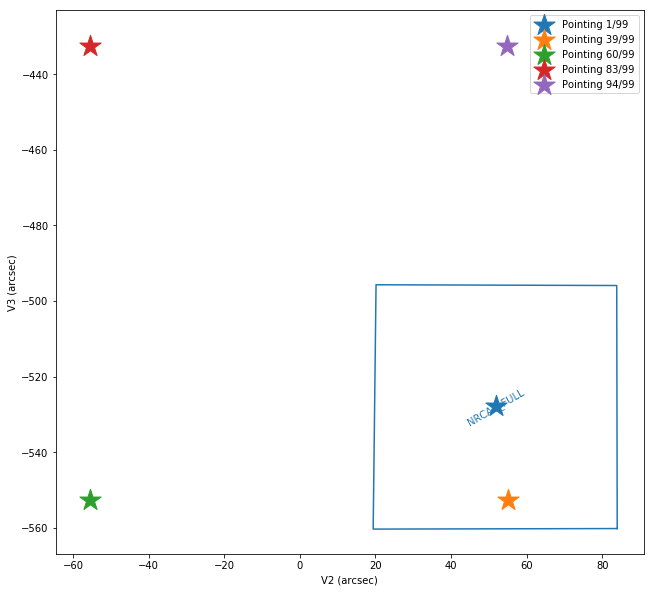

In [20]:
# Examine apertures and V2/V3 references for each array/subarray
nc_siaf = pysiaf.Siaf('NIRCam')
# nc_full = nc_siaf['NRCA1_FULL']

plt.figure(figsize=(15,10))
# for apername in sorted(nc_siaf.apernames):
#     a = apername
#     print(a)
#     if ('_FULL' in a) and ('OSS' not in a) and ('MASK' not in a) and (a[-1] != 'P'):
#         nc_siaf[a].plot(frame='tel', name_label=True, fill_color='white')
nc_siaf['NRCA3_FULL'].plot(frame='tel', name_label=True, fill_color='white')
plt.gca().invert_xaxis()

# Compare V2/V3 of targets (from .pointing file)
apt_prop = apt_inputs.AptInput()
pointing_tab = apt_prop.get_pointing_info(pointing_file, '1140')
all_pointings = set([(v2, v3, obs_id) for v2, v3, obs_id in zip(pointing_tab['v2'], 
                                                                pointing_tab['v3'], 
                                                                pointing_tab['observation_id'])])
print(all_pointings)

print('Example files for each pointing:')
print('--------------------------------')
plotted_points = []
for i_point, (v2, v3, obs_id) in enumerate(all_pointings):
    if (v2, v3) not in plotted_points:
        plotted_points.append((v2, v3))
        plt.scatter(v2, v3, marker='*', s=500, 
                    label='Pointing {}/{}'.format(i_point + 1, len(all_pointings)))
        print('{}. {}'.format(i_point + 1, obs_id))

plt.legend()

plt.show()